# **Programa Especializado en Credit Scoring con Python**
<img src="../../figuras/logo.png" width="200"/>

## 📊 **Sesión 2: Datos Crediticios y Definición del Evento de Incumplimiento**

**Docente**: Enzo Infantes Zúñiga  
**Contacto**: <enzo.infantes28@gmail.com>  
**LinkedIn**: [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

absolute_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(absolute_path, "data", "s02")

np.random.seed(42)

## 🎯 **Objetivos de la sesión**

Al finalizar esta clase el participante será capaz de:

- Comprender qué es realmente un evento de incumplimiento.
- Entender cómo cambia la definición de la PD.
- Los tipo de PD en banca.
- Introducción a curvas de default y cohortes.

## **1. ¿Qué es el Evento de Incumplimiento?**
```NO EXISTE UNA PD CORRECTA PARA TODOS LOS CASOS```

En credit scoring, el  **default** no es un concepto universal. Depende de:
- Regulación (Basilea, IFRS 9)
- Política Interna de Riesgo
- Tipo de Producto

## 📌 Definiciones formal

- **Basilea**: Normas Internacionales de Regulación Bancaria
  - Tiene más de **90 días de atraso** 
  - Existe **deterioro significativo** de la cartera
  - Existe **reestructuración/refinanciamiento** del crédito.
  
- **IFRS 9**: Empleado para el cálculo de provisiones.
  - Stage 1: Normal
  - Stage 2: Deterioro significativo 
  - Stage 3: Default

- **Política Interna de Riesgo**: Depende del objetivo de negocio y el perímetro de aplicación.
  - 30 días de atraso a 6, 9 o 12 meses
  - 60 días de atraso a 6, 9 o 12 meses
  - 90 días de atraso a 6, 9 o 12 meses

## **2. Simulación de PDs**

Numero de clientes igual a 10000 \
Un horizonte de tiempo de 12 meses \
Probabilidad de atrasarte un mes (30 dias) de 0.2 \
Probabilidad de que continues un mes con dias de atraso 0.4 

```
n_clientes = 10000
n_meses = 12

prob_mensual = 0.20 # probabilidad de atrasar el pago cada mes
prob_roll_over = 0.40 # probabilidad de seguir sin pagar

data = np.zeros((n_clientes, n_meses))

for m in range(1, n_meses):
    for c in range(n_clientes):
        prev_atraso = data[c, m-1]
        if prev_atraso == 0:
            data[c, m] = np.random.choice([0, 30], p = [1 - prob_mensual, prob_mensual])
        else:
            proximo_paso = min(prev_atraso + 30, 120) 
            data[c, m] = np.random.choice([0, proximo_paso], p = [1 - prob_roll_over, prob_roll_over])

df = pd.DataFrame(data, columns=[f"m{i+1}" for i in range(n_meses)])
```

In [49]:
df = pd.read_csv(os.path.join(data_path, "simulacion_mora.csv"))
df.head()

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,60.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,30.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
3,0.0,30.0,0.0,0.0,0.0,0.0,30.0,60.0,90.0,0.0,0.0,30.0
4,0.0,0.0,0.0,0.0,0.0,30.0,60.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ventanas = [6, 9, 12]
cohortes = [30, 60, 90]

resultados = []

for ventana in ventanas:
    fila = []
    cols_ventana = [f"m{i}" for i in range(1, ventana + 1)]
    print(cols_ventana)
    
    for cohorte in cohortes:
        # Porcentaje de clientes que alcanzaron el umbral
        tasa = (df[cols_ventana].max(axis=1) >= cohorte).mean()
        fila.append(tasa)
        print(f"Calculo para ventana: {ventana} meses y cohorte: {cohorte} días -> Tasa: {tasa:.4f}")

    resultados.append(fila)
    
df_mora = pd.DataFrame(
    resultados, 
    columns=[f"{c} días" for c in cohortes],
    index=[f"{v} meses" for v in ventanas])   # type: ignore

df_mora.head()

['m1', 'm2', 'm3', 'm4', 'm5', 'm6']
Calculo para ventana: 6 meses y cohorte: 30 días -> Tasa: 0.6762
Calculo para ventana: 6 meses y cohorte: 60 días -> Tasa: 0.2628
Calculo para ventana: 6 meses y cohorte: 90 días -> Tasa: 0.0823
['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9']
Calculo para ventana: 9 meses y cohorte: 30 días -> Tasa: 0.8294
Calculo para ventana: 9 meses y cohorte: 60 días -> Tasa: 0.4111
Calculo para ventana: 9 meses y cohorte: 90 días -> Tasa: 0.1531
['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
Calculo para ventana: 12 meses y cohorte: 30 días -> Tasa: 0.9098
Calculo para ventana: 12 meses y cohorte: 60 días -> Tasa: 0.5281
Calculo para ventana: 12 meses y cohorte: 90 días -> Tasa: 0.2194


,30 días,60 días,90 días
6 meses,0.6762,0.2628,0.0823
9 meses,0.8294,0.4111,0.1531
12 meses,0.9098,0.5281,0.2194


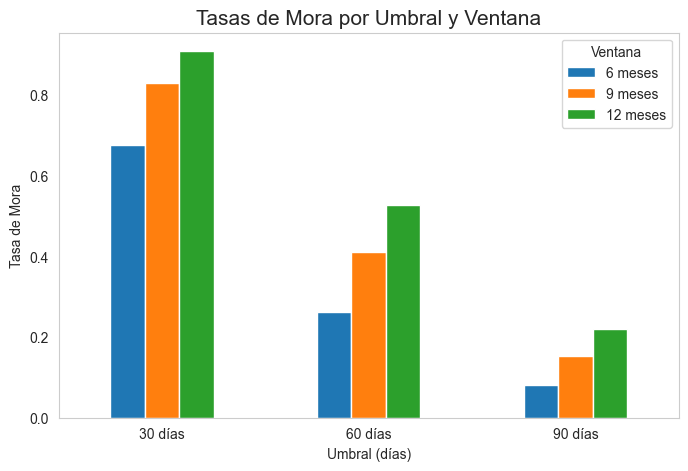

In [33]:
sns.set_style("whitegrid")

df_mora.T.plot(kind='bar', figsize=(8, 5))
plt.title('Tasas de Mora por Umbral y Ventana', fontsize=15)
plt.ylabel('Tasa de Mora')
plt.xlabel('Umbral (días)')
plt.legend(title='Ventana')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

**Sentido de Negocio**
- **PD 30dias:** Presenta mayor tasa de default, esto se deba a que hay más eventos de **mora temprana**. 
  - Sensible al ruido (olvido de pagos, problemas operativos) pero detecta deterioro de la cartera temprana.
- **PD 90dias:** Tasa de default mucho menor, al ser un evento más 'raro'. 
  - Es la definición más 'dura', filtra atrasos técnicos y suele considerarse el estándar.

Asimismo, a mayor tiempo de observación (6m - 12m), la **PD** siempre aumenta debido a que le damos más tiempo al cliente de incumplir.

## **3. Tipos de PDs 💰**

### **3.1. PD Point-in-Time (PIT)**
- Refleja condiciones actuales
- Busca periodos de estabilidad de las variables bancarias
- Sensible al ciclo económico
- Usada en IFRS 9

### **3.2. PD Through-the-Cycle (TCC)**
- Promedio a lo largo del ciclo
- Comportamiento más estable
- Usada en capital regulatorio (IRB)

### **3.3. PD Marginal**
- Útil para estimar la distribución temporal del default
- Probabilidad de incumplir en el periodo *t*, condicional a haber sobrevivido hasta el periodo t-1
$$
PD_{t} = P(Default_t \mid {Vivo Hasta_{t-1}})
$$

### **3.4. PD Acumulada**
- Probabilidad de haber incumplir hasta el periodo *t*
$$
PD Acumulada_{t} = 1 - [(1 - PD₁) × (1 - PD₂) × ... × (1 - PD_t)]
$$
- Converge a la PD de por vida (lifetime PD) cuando t → horizonte completo

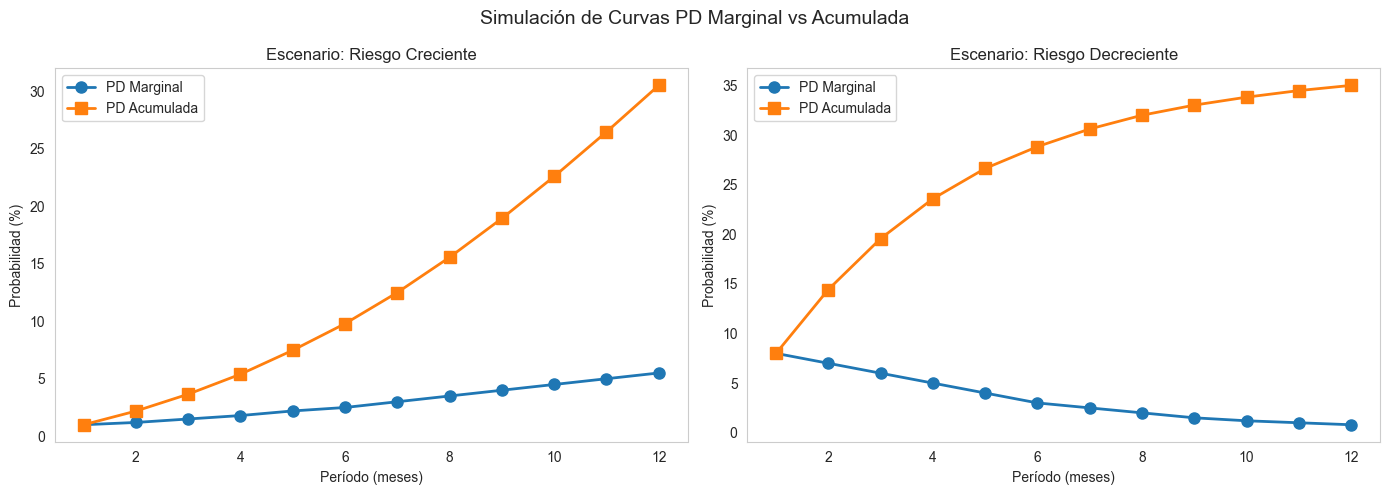

In [43]:
periodos = 12

# Escenario 1: Riesgo creciente (ej. economía empeora)
marginal_creciente = np.array([0.01, 0.012, 0.015, 0.018, 0.022, 0.025, 
                                0.03, 0.035, 0.04, 0.045, 0.05, 0.055])

# Escenario 2: Riesgo decreciente (ej. economía mejora)
marginal_decreciente = np.array([0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
                                0.025, 0.02, 0.015, 0.012, 0.01, 0.008])

# Calcular PD Acumulada
acum_creciente = 1 - np.cumprod(1 - marginal_creciente)
acum_decreciente = 1 - np.cumprod(1 - marginal_decreciente)

df_pd = pd.DataFrame({
    'Período': range(1, periodos + 1),
    'Marginal_Creciente': marginal_creciente * 100,
    'Acumulada_Creciente': acum_creciente * 100,
    'Marginal_Decreciente': marginal_decreciente * 100,
    'Acumulada_Decreciente': acum_decreciente * 100
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Escenario creciente
axes[0].plot(df_pd['Período'], df_pd['Marginal_Creciente'], 
            'o-', label='PD Marginal', linewidth=2, markersize=8)
axes[0].plot(df_pd['Período'], df_pd['Acumulada_Creciente'], 
            's-', label='PD Acumulada', linewidth=2, markersize=8)
axes[0].set_title('Escenario: Riesgo Creciente', fontsize=12)
axes[0].set_xlabel('Período (meses)')
axes[0].set_ylabel('Probabilidad (%)')
axes[0].legend()
axes[0].grid(False)

# Gráfico 2: Escenario decreciente
axes[1].plot(df_pd['Período'], df_pd['Marginal_Decreciente'], 
            'o-', label='PD Marginal', linewidth=2, markersize=8)
axes[1].plot(df_pd['Período'], df_pd['Acumulada_Decreciente'], 
            's-', label='PD Acumulada', linewidth=2, markersize=8)
axes[1].set_title('Escenario: Riesgo Decreciente', fontsize=12)
axes[1].set_xlabel('Período (meses)')
axes[1].set_ylabel('Probabilidad (%)')
axes[1].legend()
axes[1].grid(False)

plt.suptitle('Simulación de Curvas PD Marginal vs Acumulada', fontsize=14)
plt.tight_layout()
plt.show()

## **4. Ejemplos Prácticos**
1. **Admisión PP Cliente:** 90 días de atraso en un horizonte de 12 meses.
2. **Admisión TC No Bancarizados:** 60 días de atraso en un horizonte de 12 meses.
3. **Admisión TC y PP No Bancarizados:** 30 dias de atraso con horizonte de 6 meses
4. **Cobranza Premora:** mayor a 0 días de atraso a 1 mes.

Algunos filtros útiles:
1. Malos de Origen
2. Flag de clientes bancarizados
3. Indeterminados (10-60 dias)
4. Edad
5. Garantías/Convenios

## 📄​ **Conclusiones**
- No existe una unica PD correcta.
- La PD depende de:
  - Definicion del evento
  - Horizonte
  - Ciclo Economico
  - Uso del Modelo

Nota: Antes de modelar, debemos definir correctamente el evento.